# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**НАСТРОЙКА ВЫЧИСЛЕНИЙ**\
В расчете моделей использована многопоточная обработка в Parallel, расчет моделей LightGBM CatBoost проводится на GPU.
Для оптимальной производительности, число потоков вычислений на CPU можно задать в константе ниже:

In [1]:
# число ядер процессора для настройки параллельных вычислений
CPU_THREADS = 11

**ИМПОРТ БИБЛИОТЕК**

In [2]:
import pandas as pd
import numpy as np
pd.set_option("precision", 2)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# настройка окружения
sns.set_style("darkgrid", {'axes.grid' : True}) # задает темный фон и сетку на графиках
sns.set(palette='muted')

In [4]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet

In [5]:
# установка в систему lightgbm если следующая ячейка дает ошибку
#!pip install lightgbm

In [6]:
import lightgbm as lgb

In [7]:
# отключение предупреждений о будущих изменениях синтаксиса Jupyter Notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
from joblib import parallel_backend, Parallel, delayed

## Подготовка данных

In [9]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [11]:
# наиболее частые значения в данных
df.mode()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 14:49:47,0,sedan,2000,manual,0,golf,150000,0,petrol,volkswagen,no,2016-04-03 00:00:00,0,10115,2016-04-06 13:45:54


Самый популярный бренд - фольксваген, почтовый код - Гамбург. **Имеем дело с базой по Европе.**

In [12]:
# определяем число пропусков
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Многочисленные пропуски в пяти категориях, будем разбирать отдельно.

### Обработка дубликатов, пропусков, преобразование данных

In [13]:
# удаляем дубликаты
print('число записей до удаления дубликатов:', df.shape[0])
df.drop_duplicates(inplace=True)
print('число записей после удаления дубликатов:', df.shape[0])

число записей до удаления дубликатов: 354369
число записей после удаления дубликатов: 354365


**О пропусках в данных**\
Наша задача построить быструю модель для определения стоимости автомобиля. Для точной модели нужны и точные данные. В задании мы распологаем достаточно обширной базой, поэтому пропуски в наиболее важных данных решено удалить, поскольку заполнение их медианой или еще чем-то еще снизит качество модели. Представляется более важным получить именно качественную модель предсказания стоимости. В последующем, при использовании, задачу получения необходимой и достаточной информации для предсказания можно перенести на сторону интерфейса, чтобы при запросе пользователь гарантированно ее ввел.\
Конечно можно построить модель работающую и при отсутсвии многих данных, но она будет иметь большую погрешность и вряд ли будет представлять ценность для реальных пользователей сервиса.

**Подход к построению модели**\
Определение цены машины можно условно разделить на три этапа:
- определить первоначальную стоимость
- определить износ и соответственно уменьшение стоимости от первоначальной.
- учесть специфику конкретного рынка продажи

Основой расчета является первоначальная стоимость. Износ же можно косвенно определить по нескольким признакам: пробегу, году выпуска, наличию аварий и т.п. Соответственно признаки которые даны в задании можно разделить на два типа: связанные с первоначальной стоимостью автомобиля и связанные с износом/потерей стоимости.\
Признаки связанные с комплектацией машины (например тип коробки и мощность двигателя) они влияют и на превоначальную стоимость и могут влиять на износ (механическая КПП как правило более надежна, есть модели двигателей разной "удачности" и т.п.
Также стоимость может отличаться в разных регионах из-за специфики налогового и таможенного законодательства, но об этом позже.

**Главный вывод:** чтобы прогнозировать стоимость нам нужна точка отсчета, степень влияния разных признаков оценим уже при моделировании. Поэтому принципиально важно иметь все данные определяющие первоначальную стоимость: **бренд и модель автомобиля**. Пропуски в поле Brand наиболее критичны  и к счастью отсуствуют, иначе их сразу бы стоило удалить.

### Обработка признаков типа Datetime

In [14]:
# преобразуем тип данных соответствующих признаков из object в datetime
for columns in ['DateCrawled', 'DateCreated', 'LastSeen']:
    df[columns] = pd.to_datetime(df[columns],infer_datetime_format=True)

In [15]:
df[['DateCrawled', 'DateCreated', 'LastSeen']].describe().transpose()

,count,unique,top,freq,first,last
DateCrawled,354365,271174,2016-03-24 14:49:47,7,2016-03-05 14:06:22,2016-04-07 14:36:58
DateCreated,354365,109,2016-04-03 00:00:00,13718,2014-03-10 00:00:00,2016-04-07 00:00:00
LastSeen,354365,179150,2016-04-06 13:45:54,17,2016-03-05 14:15:08,2016-04-07 14:58:51


**Вывод:**
- DateCreated имеет 109 уникальных значений, т.е. в течении 700+ дней разброса выборки объявления подавались только 108 дней. Данные синтетические или подавать объявления можно было только один день в неделю.
- имеем противоречие в данных: `DateCrawled` (дата скачивания из базы), `DateCreated` (дата создания объявления)  имеют самое позднее значение 2016-04-07,  и одновременно имеем массу автомобилей с регистрацией `RegistrationYear` в 2017-2019 годах. Вопрос преподавателю прояснил, что эти признаки можно удалить.\
Для нашего исследования из временных данных хотелось бы получить:
- время экспозиции лота (дата продажи - дата размещения объявления)
- активность просмотров \
Малое время экспозиции говорило бы о привлекательной цене, меньшей или близкой к рыночной, но для этого как минимум не хватает записи о дате продажи. В итоге из трех признаков `'DateCrawled', 'DateCreated', 'LastSeen'` для исследования мы не можем ничего использовать - **удаляем**.

In [16]:
# удаляем признаки datetime
df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1, inplace=True)

### Обработка категориальных признаков

Как уже упоминалось наиболее важным после признака `Brend` представляется признак 'Model', поэтому его обработку проводим в первую очередь.

In [17]:
# список категориальных признаков
df.describe(include='object').transpose()

,count,unique,top,freq
VehicleType,316875,8,sedan,91457
Gearbox,334532,2,manual,268249
Model,334660,250,golf,29232
FuelType,321470,7,petrol,216349
Brand,354365,40,volkswagen,77012
NotRepaired,283211,2,no,247158


#### **Brand**

In [18]:
# число пропусков
df['Brand'].isna().sum()

0

In [19]:
#df['Brand'].value_counts()

**Вывод:** С названиями брендов все в порядке. Пропусков нет. Обработка не требуется.

#### **Model**

In [20]:
df['Model'].isna().sum()

19705

In [21]:
df['Model'].value_counts().head()

golf     29232
other    24420
3er      19761
polo     13066
corsa    12570
Name: Model, dtype: int64

In [22]:
# замена пропусков на "other"
df.loc[df['Model'].isna(), 'Model'] = 'other'

**Вывод:** Имеем 19705 пропусков и категорию `other` с 24420 записями. Это определение "средней температуры по больнице", но раз данных около 10% от всей выборки, то оставим. **Пропуски заменяем на `other`**\
Визуальный анализ названий моделей орфографических ошибок не выявил, поэтому дополнительную обработку не производим.

#### **FuelType**

In [23]:
df['FuelType'].isna().sum()

32895

In [24]:
df['FuelType'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [25]:
# объединяем записи petrol-gasoline
df.loc[df['FuelType'].isna(), 'FuelType'] = 'petrol'
df.loc[df['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

**Вывод:** Имеем 32895 пропусков. C названиями в категории все  нормально, кроме **`petrol` и `gasoline`**. Это одно и то же, `gasoline` американизм, поэтому объединяем эти записи в `petrol`. Что касается пропусков, поскольку бензиновых машин оказалось несоизмеримо больше других типов вместе взятых, запишем эти данные также в `petrol`\
Удивительно, что отсутствуют дизельные двигатели. Возможно ошибка.

#### **Gearbox**

In [26]:
# число пропусков
df['Gearbox'].isna().sum()

19833

In [27]:
df['Gearbox'].value_counts()

manual    268249
auto       66283
Name: Gearbox, dtype: int64

In [28]:
df.loc[df['Gearbox'].isna(), 'Gearbox'] = 'unknown'

**Вывод:** Имеем 19833 пропуска. C названиями в категории все нормально. Заменять в данном случае по большинству рисковано, пропусков достаточно много, а тип КП может существенно влиять на стоимость авто, поэтому добавим категорию **`unknown`**.

#### **VehicleType**

In [29]:
# число пропусков
df['VehicleType'].isna().sum()

37490

In [30]:
df['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

**В `VehicleType` 37490 пропусков и близкая по смыслу категория `other` - 3288 записей. Заменяем пропуски на моду расчитанную для данной модели по бренду**

In [31]:
# эксперименты
# df.groupby('Model')['VehicleType'].transform(lambda x: x.value_counts().index[0])
# df.groupby(by=['Brand', 'Model'])['VehicleType'].apply(lambda x: x.mode()[0])

In [32]:
df['VehicleType'].fillna(
    df.groupby(by=['Brand', 'Model'])['VehicleType']
    .transform(lambda x: x.value_counts().index[0]),
    inplace=True
)

#### **NotRepaired**

In [33]:
df['NotRepaired'].isna().sum()

71154

In [34]:
df['NotRepaired'].value_counts()

no     247158
yes     36053
Name: NotRepaired, dtype: int64

**Вывод:** Имеем 71154 пропуска. C названиями в категории все нормально. Заменять в данном случае по большинству рисковано, пропусков достаточно много, а наличие истории ремонтов может существенно влиять на стоимость авто, поэтому добавим категорию **`unknown`**.

In [35]:
df.loc[df['NotRepaired'].isna(), 'NotRepaired'] = 'unknown'

In [36]:
# проверка 
df['NotRepaired'].value_counts()

no         247158
unknown     71154
yes         36053
Name: NotRepaired, dtype: int64

#### **PostalCode**

In [37]:
df['PostalCode'].nunique()

8143

**Вывод:** Почтовый код продавца скорее всего будет влиять на цену автомобиля. В разных странах могут быть разные таможенные и налоговые условия. Близость к морю будет способствовать быстрому износу-коррозии кузова и тоже влиять на цену. Может влять удаленность от континента для островных территорий и т.п. В первом приближении этот фактор решено не учитывать.\
В признаке 8134 уникальных значения, их вполне можно заменить на кластеры соответствующие странам и это уже должно дать результат. С ходу список zip кодов не нашел, поэтому вариант отложен.

### Обработка количественных данных

In [38]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'NumberOfPictures', 'PostalCode'],
      dtype='object')

In [39]:
df[['Price', 'PostalCode', 'Power', 'Kilometer',
       'RegistrationYear', 'RegistrationMonth']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,354365.0,4416.68,4514.18,0.0,1050.0,2700.0,6400.0,20000.0
PostalCode,354365.0,50508.50,25783.10,1067.0,30165.0,49413.0,71083.0,99998.0
Power,354365.0,110.09,189.85,0.0,69.0,105.0,143.0,20000.0
Kilometer,354365.0,128211.36,37905.08,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationYear,354365.0,2004.23,90.23,1000.0,1999.0,2003.0,2008.0,9999.0
RegistrationMonth,354365.0,5.71,3.73,0.0,3.0,6.0,9.0,12.0


**Выводы**
- `Price` - стоимость не может быть нулевой, тем более это целевой признак, поэтому **нулевые значения удалим**
- `RegistrationYear` - очевидны ошибки, есть и 1000 год и 9999. Верхний диапазон установим 2021 год. Задача определения цены антикварных автомобилей перед нами не стоит и к тому же имеет другие принципы расчета. Нижний диапазон установим 1960 годом (60 лет - законодательно установленный в большинстве стран возраст для антиквариата)
- `Power`  - тут можно заполнить медианой для машин одного бренда и модели 
- `Kilometer` - на данном этапе недостатков не видно, оставляем как есть
- `RegistrationMonth` - без изменений
- `NumberOfPictures` - содержательных записей нет, признак можно **удалить**
- `PostalCode` - категориальный признак, его описан выше.

#### NumberOfPictures - число фотографий

Сразу удаляем столбец без данных

In [40]:
# удаляем признак NumberOfPictures
df = df.drop('NumberOfPictures', axis=1)

#### **Price - Целевой признак**

In [41]:
# обработка Price
# число записей с нулевой стоимостью
print('число записей с нулевым Price:', df.loc[df['Price'] == 0, 'Price'].count())
# удаляем записи с нулевым целевым признаком
df = df.loc[df['Price'] != 0]

число записей с нулевым Price: 10772


#### **RegistrationYear - год регистрации**

In [42]:
# обработка `RegistrationYear`
print('число записей с годом регистрации позже 2021:', df.loc[df['RegistrationYear'] > 2021, 'RegistrationYear'].count())
print('число записей с годом регистрации до 1960:', df.loc[df['RegistrationYear'] < 1960, 'RegistrationYear'].count())
# удаляем записи с годом регистрации после 2021
df = df.loc[df['RegistrationYear'] <= 2021]
# удаляем записи с годом регистрации до 1960
df = df.loc[df['RegistrationYear'] > 1960]

число записей с годом регистрации позже 2021: 86
число записей с годом регистрации до 1960: 340


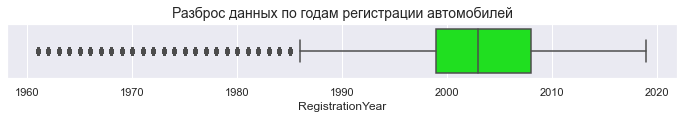

In [43]:
# визуализируем полученный результат по годам регистрации
fig = plt.figure(figsize=(12,1))
plt.title('Разброс данных по годам регистрации автомобилей', fontsize=14)
sns.boxplot(x=df['RegistrationYear'], color='Lime');

Осталось достаточно много выбросов. Дополнительно очистим данные от значений лежащих ниже нижнего/левого "уса", т.е. старше 1985 года.

In [44]:
# удаляем записи с годом регистрации до 1985
df = df.loc[df['RegistrationYear'] > 1985]

#### **Месяц регистрации**

Оцениваем общее число пропусков (нулевой месяц регистрации):

In [45]:
print('число записей с нулевым месяцем регистрации:', df.loc[df['RegistrationMonth'] == 0].shape[0])

число записей с нулевым месяцем регистрации: 31675


Пропусков очень много. И удалять их все нет смысла. Нас интересует возраст машины, месяц выпуска должен рассматриваться во взаимосвязи с годом выпуска. Поэтому параметр месяца для более старых машин будет вносить лишь небольшую погрешность и его можно заменить на 1. Для трехлетней машины это даст погрешность к возрасту от 1/36 до 1/24. Оценим число данных с пропусками по месяцу для разных годов

In [46]:
# число пропусков по признаку месяц регистрации по годам
df.loc[df['RegistrationMonth'] == 0].groupby(by='RegistrationYear')['RegistrationMonth'].count().tail()

RegistrationYear
2015     153
2016    2479
2017    2527
2018     803
2019       5
Name: RegistrationMonth, dtype: int64

Таких данных для машин до 2017 года включительно оказалось меньше 3000, поэтому можно их удалить. Остальные пропуски **заменяем по "пессимистичному" варианту - на `1`**

In [47]:
# # удаляем записи с месяцем регистраиции 0 и годом выпуска от 2017
df = df.loc[df.index.isin(
     df.loc[~( (df['RegistrationYear'] >= 2017) & (df['RegistrationMonth'] == 0) ) ].index)]

In [48]:
# заполняем "пропуски", т.е. значения с месяцем регистрации `0` на `1`
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

In [49]:
# размер базы после обработки
df.loc[~( (df['RegistrationYear'] >= 2017) & (df['RegistrationMonth'] == 0) ) ].shape

(334515, 12)

#### **Создаем новый признак "Age" -  возраст автомобиля** 
заменяем признаки год регистрации и месяц регистрации новым признаком - возраст автомобиля

In [50]:
# определим месяц регистрации самого молодого автомобиля в нашей базе
df.loc[df['RegistrationYear']==2019]['RegistrationMonth'].max()

12

**Точкой отсчета возраста автомобиля будет декабрь 2019 года.** Это возраст самого молодого автомобиля в нашей базе. И это позволит сохранить актуальность модели даже спустя значительное время, поскольку мы используем не абсолютное значение даты регистрации а именно возраст автомобиля который кореллирует с износом и его можно будет пресчитать на новую дату.

In [51]:
# вводим константу - базис отсчета возраста
BASE = [2019, 12]
df['Age'] = ((BASE[0] - df['RegistrationYear'])*12 + BASE[1] - df['RegistrationMonth'])

In [52]:
# удаляем ставшие "лишними" признаки 'RegistrationYear', 'RegistrationMonth'
df = df.drop(['RegistrationYear', 'RegistrationMonth'], axis=1)

In [53]:
# проверка обработки
df.head(3)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode,Age
0,480,sedan,manual,0,golf,150000,petrol,volkswagen,unknown,70435,323
1,18300,coupe,manual,190,other,125000,petrol,audi,yes,66954,103
2,9800,suv,auto,163,grand,125000,petrol,jeep,unknown,90480,184


#### Power

Имеем большой разброс значений от 0 до 20000 л.с. что говорит о пропусках и выбросах. С верхней границы диапазона обрезаем данные по перцентилю 99.8% и производим замену нулевых значений модой мощности для данной модели-бренда автомобиля.\
Высокая мощность характерна для спорткаров, если мы отсечем эти данные это не существенно, поскольку цена для них определяется индивидуально и по другим принципам чем для массовых авто.

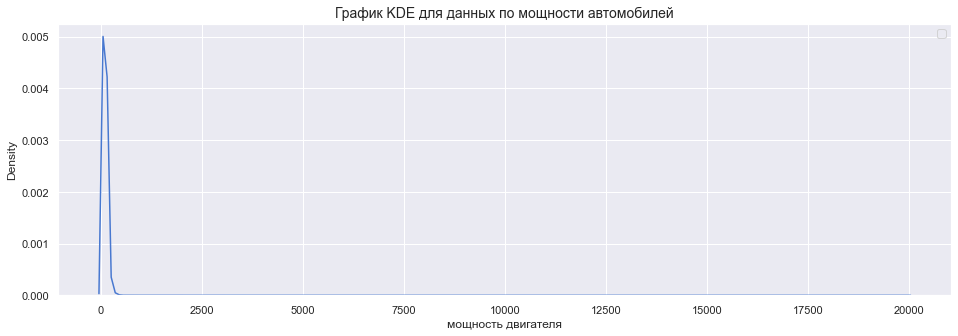

In [54]:
fig = plt.figure(figsize=(16,5))
plt.title('График KDE для данных по мощности автомобилей', fontsize=14)
sns.kdeplot(df['Power']);
plt.legend(''),  plt.xlabel('мощность двигателя');

In [55]:
df['Power'].isna().sum()

0

In [56]:
# число записей с нулевой мощностью
df['Power'].value_counts()[0]

33506

In [57]:
# мощность для 99,8 пеерцентиля
np.percentile(df['Power'], 99.8)

400.0

In [58]:
# # удаляем записи с мощность / Power более 400 (по перцентилю 99.8)
df = df.loc[df.index.isin(
     df.loc[~( df['Power'] > 400) ].index)]

In [59]:
df.shape

(333849, 11)

In [60]:
# записи с мощность / Power 0  заполняем медианой мощности для модели
# для упрощения процедуры заменяем 0 на nan для использования в последующем fillna
df.loc[df['Power'] == 0, 'Power'] = np.nan
df['Power'].fillna(df.groupby('Model')['Power'].transform(lambda x: x.mode()[0]), inplace=True)

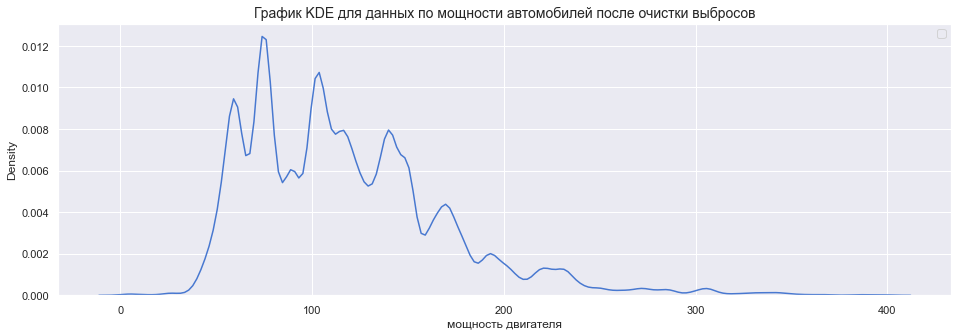

In [61]:
# проверка результата
fig = plt.figure(figsize=(16,5))
plt.title('График KDE для данных по мощности автомобилей после очистки выбросов', fontsize=14)
sns.kdeplot(df['Power']);
plt.legend(''),  plt.xlabel('мощность двигателя');

## Обучение моделей

**Решено провести обучение нескольких видов моделей:**
- LinearRegressor (Это будет BaseLine)
- Elastic
- RandomForestRegressor
- LightGBM\

Признаки будут созданы в двух вариантах с кодирование (суффикс ohe) и без кодирования.

Разделяем выборку на тренировочные/тестовые данные:

In [62]:
features = df.drop('Price', axis=1)
target = df['Price']

**Создаем вариант признаков с кодирование OHE**

In [63]:
# создаем список категориальных признаков
# features_category = list(df.describe(include='object').columns)
features_category = ['Brand', 'Model', 'VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']

In [64]:
features_ohe = pd.get_dummies(features, drop_first=True, columns=features_category)
features_ohe.head(3)

,Power,Kilometer,PostalCode,Age,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,...,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,FuelType_electric,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_unknown,NotRepaired_yes
0,75.0,150000,70435,323,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
1,190.0,125000,66954,103,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
2,163.0,125000,90480,184,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


Чтобы вариант данных совпадал по набор с кодированием OHE и без, делаем разбивку **с одним занчением random_state**:

In [65]:
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(features_ohe, target, test_size=0.2, random_state=13) 

In [66]:
X_train, X_test, y_train_2, y_test_2 = train_test_split(features, target, test_size=0.2, random_state=13) 

In [67]:
# проверка
print('если получен (0) разбивка признаков на train/test с кодированием и без кодирования - совпадают:.....',
      (y_train -  y_train_2 ).sum() + (y_test -  y_test_2).sum())

если получен (0) разбивка признаков на train/test с кодированием и без кодирования - совпадают:..... 0


**Разбивка на обучающую/тестовую выборки выполнена, целевой признак совпадает для всех вариантов: y_test, y_train**

**В sklearn нет готового скорера для RMSE поэтому создаем:**

In [68]:
# создаем функцию и скорер RMSE  
def rmse(y1, y2):
     return  mean_squared_error(y1, y2) ** 0.5

rmse_score = make_scorer(rmse, greater_is_better=False)

### LinearRegression

In [69]:
def grid_lr(X_train_ohe, y_train):
    model = LinearRegression()
    params = {} # словарь для перебора гиперпараметров
    grid = GridSearchCV(model, params, 
                        cv=2, scoring=rmse_score, 
                        n_jobs=CPU_THREADS, verbose=True)
    grid.fit(X_train_ohe, y_train)
    return grid

In [70]:
%%time
grid_LR = grid_lr(X_train_ohe, y_train)
print('лучшие параметры:', grid_LR.best_params_)
print('лучшая оценка RMSE: {:.2f}'.format(grid_LR.best_score_ ))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=11)]: Done   2 out of   2 | elapsed:    3.5s finished


лучшие параметры: {}
лучшая оценка RMSE: -2608.44
Wall time: 6.78 s


In [71]:
%%time
print('Модель LinearRegression')
print('RMSE предсказания:', rmse(y_test, grid_LR.predict(X_test_ohe)) )

Модель LinearRegression
RMSE предсказания: 2598.521352355794
Wall time: 66.8 ms


In [72]:
# Модель регрессии ElasticNet
def grid_elastic(X_train_ohe, y_train):
    model = ElasticNet(random_state=210417)
    # вариация параметра l1_ratio позволяет испытать разные модели штрафов: 
    # 0 - Grid, 1 - Lasso, и все промежуточные значения это Elastic
    params = {   'alpha': [1], 
                 'l1_ratio': [0.01, 0.5, 0.7, 0.9, 0.99]                
    } 
    
    grid = GridSearchCV(model, params, 
                        cv=2, scoring=rmse_score, 
                        verbose=True, n_jobs=CPU_THREADS)
    # добавлен параметр samle_weight чтобы повысить значимость образцов с высоким дебетом
    grid.fit(X_train_ohe, y_train)
    return grid

In [73]:
%%time
with parallel_backend('threading'):           
       grid_ELAST = grid_elastic(X_train_ohe, y_train)
print('лучшие параметры:', grid_ELAST.best_params_)
print('лучшая оценка RMSE: {:.2f}'.format(grid_ELAST.best_score_))

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  10 out of  10 | elapsed:    9.7s finished


лучшие параметры: {'alpha': 1, 'l1_ratio': 0.99}
лучшая оценка RMSE: -2713.41
Wall time: 12.8 s


In [74]:
%%time
print('Модель ElasticNet')
print('RMSE предсказания:', rmse(y_test, grid_ELAST.predict(X_test_ohe)))

Модель ElasticNet
RMSE предсказания: 2714.2094533750565
Wall time: 73.3 ms


### RandomForestRegressor

Рассчитываем параметры для оценки размеров дерева:

In [75]:
# общее число признаков 
X_train_ohe.shape[1]

306

In [76]:
# оцениваем примерный диапазон для параметра 'min_samples_leaf'
df_base = pd.read_csv('/datasets/autos.csv')
df_base.groupby(by=['Brand', 'Model', 'Power', 'Gearbox'])['RegistrationYear'].count().mean()

21.935355202530776

In [77]:
%%time
model_RF = RandomForestRegressor(random_state = 210601)

params_RF = {    
    'max_depth': [90],
    'n_estimators': [40],
    'min_samples_leaf' : [5]   
}

grid_RF = GridSearchCV(model_RF, params_RF, scoring = rmse_score,
                       cv=8, return_train_score=True,  
                       n_jobs=CPU_THREADS, verbose=1)

with parallel_backend('threading'):           
        grid_RF.fit(X_train_ohe, y_train)
        
print('лучшие параметры:', grid_RF.best_params_)
print('лучшая оценка RMSE: {:.2f}'.format(grid_RF.best_score_))


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   5 out of   8 | elapsed:  5.4min remaining:  3.2min
[Parallel(n_jobs=11)]: Done   8 out of   8 | elapsed:  5.4min finished


лучшие параметры: {'max_depth': 90, 'min_samples_leaf': 5, 'n_estimators': 40}
лучшая оценка RMSE: -1605.27
Wall time: 6min 13s


In [78]:
%%time
print('Модель RandomForestRegressor')
print('RMSE предсказания:', rmse(y_test, grid_RF.predict(X_test_ohe)))

Модель RandomForestRegressor
RMSE предсказания: 1575.3714340703932
Wall time: 634 ms


### LightGBM

Настройка параметров проводилась в соответствии с рекомедациями официальной документации LightGBM https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [79]:
# подготовка датасета для lightgbm
X_train_lgb, X_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(X_train_ohe, y_train, test_size=0.2, random_state=13)
lgb_train = lgb.Dataset(X_train_lgb, y_train_lgb )
lgb_eval = lgb.Dataset(X_valid_lgb, y_valid_lgb, reference=lgb_train)

In [85]:
%%time

# словарь с параметрами
params = {
     'num_iterations': 190,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'root_mean_squared_error'},
    'num_leaves': 1000,
    'min_data_in_leaf': 5,
    'max_bin': 100,
    'learning_rate': 0.02,
    'device_type': 'gpu',
    'verbose': 1
}

print('Старт обучения...')
# train

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=30,
                valid_sets=lgb_eval,
                early_stopping_rounds=20
                )


Старт обучения...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 213663, number of used features: 302
[LightGBM] [Info] Using GPU Device: gfx1030, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (1.63 MB) transferred to GPU in 0.002004 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 4534.770915
[1]	valid_0's rmse: 4433.78
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 4360.11
[3]	valid_0's rmse: 4288.1
[4]	valid_0's rmse: 4217.71
[5]	valid_0's rmse: 4149.03
[6]	valid_0's rmse: 4081.97
[7]	valid_0's rmse: 4016.22
[8]	valid_0's rmse: 3952.22
[9]	valid_0's rmse: 3889.66
[10]	valid_0's rmse: 3828.44
[11]	valid_0's rmse: 3768.59
[12]	valid_0's rmse: 3710.23
[13]	v

In [86]:
%%time
print('Модель LightGBM')
print('RMSE предсказания:', rmse(y_test, 
                                     gbm.predict(X_test_ohe, num_iteration=gbm.best_iteration)))

Модель LightGBM
RMSE предсказания: 1552.6090873994135
Wall time: 373 ms


### Вывод
Обучено несколько моделей. Использование признаков унифицировано - везде использовалось кодирование OHE. Удалось применить GPU при расчете модели LightGBM.

## Анализ моделей

Скорость работы моделей в итоговой таблице взята из результатов %%time ячеек. Способа передать полученное значение переменной не нашел, поэтому данные просто внесены вручную константами. При исполнении на других ПК эти цифры будут отличаться, но общая пропорция между временем исполнения моделей сохранится.

In [ ]:
#создаем датафрейм с итогами вычислений

summary = [
    [-grid_LR.best_score_, rmse(y_test, grid_LR.predict(X_test_ohe)), 6.78, 66.8],
    [-grid_ELAST.best_score_, rmse(y_test, grid_ELAST.predict(X_test_ohe)), 12.8, 73.3],
    [-grid_RF.best_score_, rmse(y_test, grid_RF.predict(X_test_ohe)), ((6*60+13) * 50), 634],
    [1561, rmse(y_test, gbm.predict(X_test_ohe, num_iteration=gbm.best_iteration)), 28.1, 373] 
]
df_summary = pd.DataFrame(summary, 
                          index =['LinearRegression', 'ElasticNet', 'RandomForestRegressor', 'LightGBM'],
                          columns=['RMSE_train', 'RMSE_test', 'train_sec', 'predict_ms'])


Text(0.5, 1.0, 'меньше - лучше')

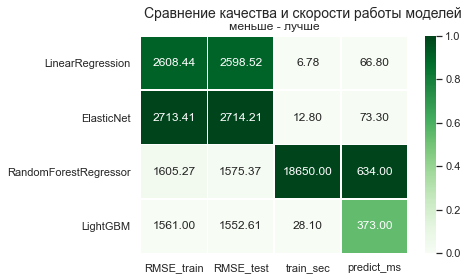

In [88]:
scaled_df = (df_summary - df_summary.min(axis=0))/(df_summary.max(axis=0) - df_summary.min(axis=0))
sns.heatmap(scaled_df, annot=df_summary, fmt='.2f', linewidths=.5, cmap="Greens")
plt.suptitle('Cравнение качества и скорости работы моделей', fontsize=14)
plt.title('меньше - лучше', fontsize=12)


### Вывод:

**LightGBM лучшая модель** - она обеспечивает лучшее качество предсказания RMSE 1561 при скорости обучения сравнимой с линейной регрессией 28 сек и имеет среднюю скорость работы модели при предсказании - 373 мс

Скорость обучения будет сильно зависеть от аппаратной части используемого ПК. Выводы сделаны из предположения, что обучение модели производится на специализированном ПК, а использование на более простых устройствах.

Лучшее качество предсказания дала модели LightGBM - RMSE 1561 и RandomForest - 1599. Разновидности линейной регрессии  Linearregression и ElasticNet значительно хуже - RMSE 2608 и 2713. При этом они обучаются наиболее быстро - в пределах 13 сек.
Чуть хуже скорость обучения у LightGBM - 28 сек. Труднее всего оказалось обучение RandomForest, реально на это ушло около суток, поскольку GridSearch проводит сплошной перебор значений. В таблице указано индикативное время для сетки на 50 итераций, когда диапазон гиперпараметров примерно понятен.
Скорость работы готовой модели у всех вариантов не превышает секуннды, линейные регрессии до 80 мс, RandomForest и здесь самый медленный - 634 мс, и LightGBM - 373 мс.